In [1]:

import matplotlib.pyplot as plt
import scipy
import numpy as np
import math

from scipy.optimize import minimize, Bounds


V_const = 10**14

class Const:
    #eta = 1e-3
    #rho_f = 1000

    eta = 0.36e-3 # Viscosity of acetone
    rho_f = 789  # Density of acetone
    # K = 10e-6
    T = 293.8
    k_b = scipy.constants.k
    runs = 10000
    # V = 10**6
    BaTi_density = 4200


def MSD_fitting_func(t,m, K, r, V):
    trap_const = K
    use_mass = m
    m_f = 4/3*np.pi*r**3*Const.rho_f
    t_k = (6 * np.pi * r * Const.eta)/trap_const
    t_f = (Const.rho_f*r**2)/Const.eta
    t_p = m/(6 * math.pi * r * Const.eta)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a = t_p
    b = -1*np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    term_1 = scipy.special.erfcx(roots[0]*np.sqrt(t)) / (roots[0]*(roots[0] - roots[1])*(roots[0] - roots[2])*(roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1]*np.sqrt(t)) / (roots[1]*(roots[1] - roots[0])*(roots[1] - roots[2])*(roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2]*np.sqrt(t)) / (roots[2]*(roots[2] - roots[1])*(roots[2] - roots[0])*(roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3]*np.sqrt(t)) / (roots[3]*(roots[3] - roots[1])*(roots[3] - roots[2])*(roots[3] - roots[0]))

    D = Const.k_b*Const.T / (6*np.pi*Const.eta*a)

    return np.real(V*(2*Const.k_b*Const.T / trap_const+ 2*Const.k_b*Const.T/(m)*(term_1+term_2+term_3+term_4)))


def MSD_fitting_const_rho(t, MSD_data, K_guess, a_guess, V_guess, m_guess, bounds=None):
    initial_guess = [V_guess, a_guess, K_guess]
    def least_squares_func(x):
        # Fit for mass only, using K and a as constants
        K = x[2] / 10**6

        V = x[0] *V_const
        a = x[1]*10**-6
        m = 4/3*np.pi*a**3*(Const.BaTi_density + Const.rho_f/2)
        msd_model = MSD_fitting_func(t, m, K, a, V)
        # Least squares: minimize the sum of squared differences
        print_negative_indices(np.real(MSD_data), "data")
            # print(f"K: {K}, V: {V}, a: {a}, m: {m} ")
        print_negative_indices(np.real(msd_model), "model")
            # print(f"K: {K}, V: {V}, a: {a}, m: {m} ")

        return np.sum((np.log(np.real(MSD_data)) - np.log(np.real(msd_model))) ** 2)

    optimal_parameters = scipy.optimize.minimize(least_squares_func, initial_guess, bounds=bounds, method="Nelder-Mead", options={'maxiter':10000,'xatol': 1e-12, 'fatol': 1e-12})
    return optimal_parameters

def print_negative_indices(arr, str):
    """Prints the indices of negative elements in an array.

    Args:
        arr: A list of numbers.
    """
    for i in range(len(arr)):
        if arr[i] < 0:
            print(f"index {i} is less than zero." + " " + str)
            return True


In [2]:
import os
from nptdms import TdmsFile

def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    # Returns a list of args, and traces
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }
def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)


def compute_stationary_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in np.array(range(n-1))+1:
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)
    msd[0] = np.average(time_trace**2)
    return msd[1:], lag_times

def compute_stationary_msd_fast(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in np.array(range(1, n, 1)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)
    msd[0] = np.average(time_trace**2)
    return msd[1:], lag_times


def j_msd(signal, lags):
    MSDs = np.zeros(len(lags))
    ls = lags
    for i in range(1, len(ls)):
        counter = 0
        #for j in range(len(signal)-ls[len(ls)-1]-1):
        for j in range(10000):
            MSDs[i] += (signal[j] - signal[ls[i]+j])**2
            counter+=1

        MSDs[i] /= counter
    MSDs[0] = np.average(signal**2)
    return MSDs

def low_freq_fit(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    #A = 4000
    A = 4.66255013e+03
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + 15909216.44677893/3)
    RC_high_pass = x_c / (x_c +C)
    return np.abs(Sallen_key)

def transfer(freq, response):
    # df = pd.read_csv(r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\no_filter_response.txt")
    # freqs = np.array(df[df.keys()[0]])
    # print(freqs.max())
    # print(freqs.min())
    # r = np.array(df[df.keys()[1]])
    # # Debug: Check for zeros in r
    # if np.any(r == 0):
    #     print("Warning: Interpolation data contains zeros in the response column.")
    #
    # interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")


    def low_freq_fit(f):
        C = 1 / (10**-6*1000)
        x_c = 1j*f*2*np.pi
        #A = 4000
        A = 4.66255013e+03
        Sallen_key = x_c**2 / (x_c**2 + A*x_c + 15909216.44677893/3)
        RC_high_pass = x_c / (x_c +C)
        return np.abs(Sallen_key)

    print(low_freq_fit(freq)[low_freq_fit(freq) <= 0])

    return np.array(response[1:] / low_freq_fit(freq)[1:])



In [3]:

# freq = np.logspace(0, 3, 5000)  # Frequencies from 10 Hz to 1 MHz
# flat_psd = np.ones_like(freq)  # Flat PSD
# psd_combined_f = transfer(freq, flat_psd)
#
# plt.plot(freq, (1/psd_combined_f), ".")
# # plt.xscale("log")
# plt.yscale("log")
# plt.title("Transfer Funtion")

Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\New_Detector_data\use_data-selected 0
data_col  X


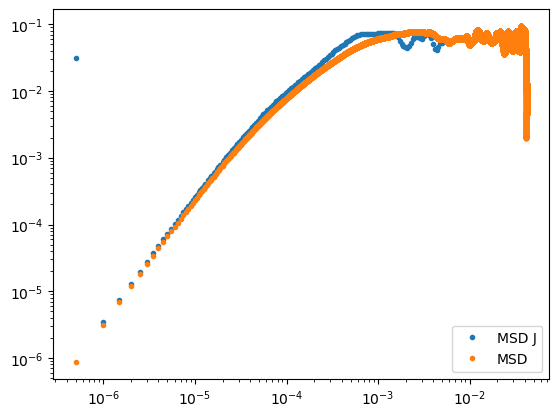

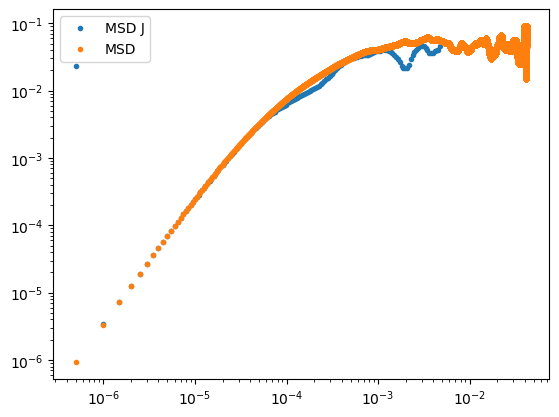

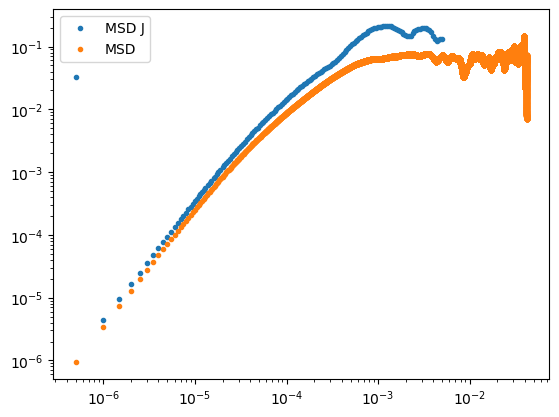

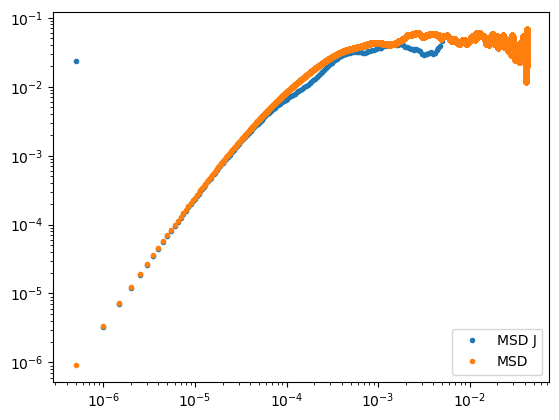

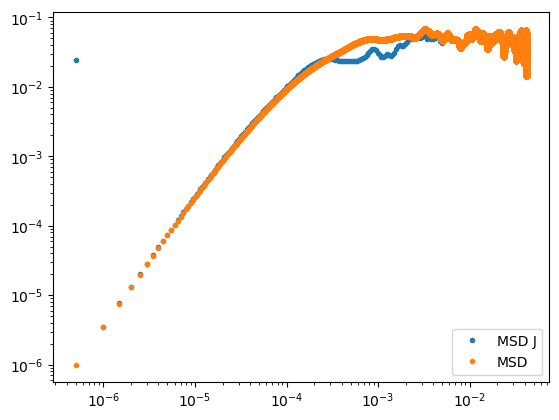

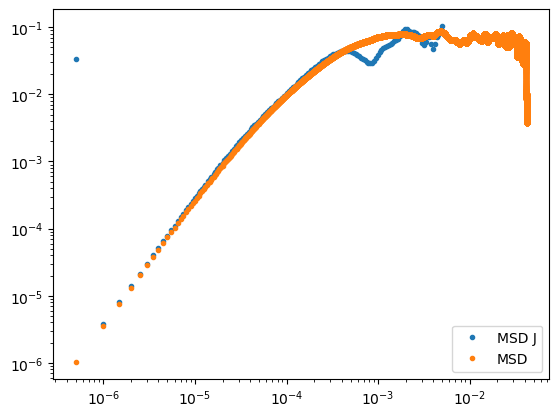

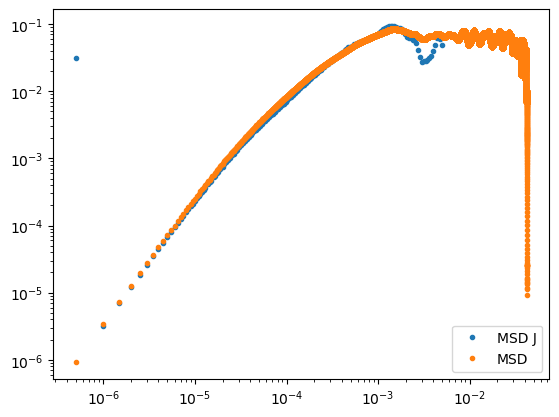

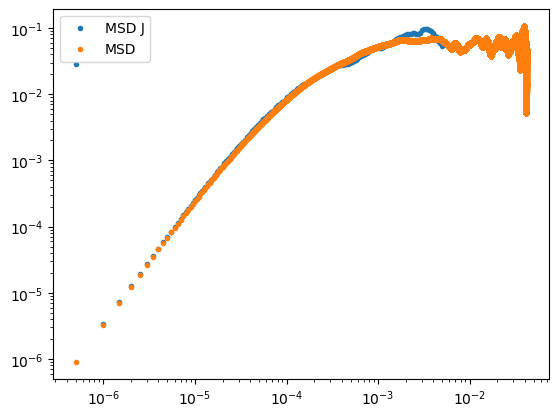

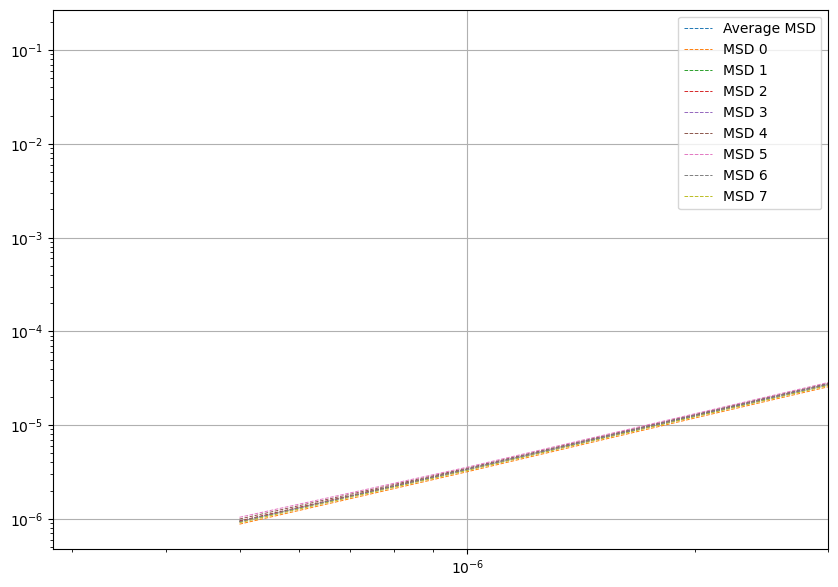

In [4]:
filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\New_Detector_data\use_data-selected"
offset = 100910524
num_files = 1
traces_per_file = 8
sampling_rate = 200000000
tikonov = True
high_pass = 100
bin_number = 100

traces = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
times = np.arange(0, len(traces[0]['series']))* (1/sampling_rate)

transfered_traces = []

if tikonov:
    lda = np.abs(low_freq_fit(high_pass))
    for trace in traces:
        # apply the transfer and convert back
        freq_domain_data = scipy.fft.fft(trace['series'])
        frequencies = scipy.fft.fftfreq(len(trace['series']), times[1] - times[0])
        transfer = low_freq_fit(frequencies)

        freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
        data = np.fft.ifft(freq_domain_data_transfer)

        transfered_traces.append(np.real(data))
else:
    for trace in traces:
        # apply the transfer and convert back
        freq_domain_data = scipy.fft.fft(trace['series'])
        frequencies = scipy.fft.fftfreq(len(trace['series']), times[1] - times[0])
        transfer_f = transfer(frequencies, freq_domain_data)
        trace_out = np.fft.ifft(transfer_f)

        transfered_traces.append(np.real(trace_out))

binned_traces = []

# Reverse it lol
for trace in transfered_traces:
    series = bin_data(trace, bin_number)
    binned_traces.append(series)

all_msd = []

for series in binned_traces:
    msd, lag_times = compute_stationary_msd(series, bin_number/sampling_rate)
    # lags_j = i*(bin_number/sampling_rate) for i in range(le)
    # DELETE
    final_power = 4
    powers = np.linspace(0, final_power, 200)
    ls = np.array( np.floor(10**powers), dtype = np.int64)
    ls = np.unique(ls)
    msd_j = j_msd(series, ls)
    plt.plot(ls * bin_number / sampling_rate, msd_j, ".", label = "MSD J")
    plt.plot(lag_times, msd, ".", label = "MSD")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()
    all_msd.append(msd)

avg_msd = np.mean(all_msd, axis=0)

plt.figure(figsize=(10, 7))
plt.plot(lag_times, avg_msd, linewidth=.7, linestyle="dashed",label='Average MSD')

for i in range(len(all_msd)):
    plt.plot(lag_times, all_msd[i], linewidth=.7, linestyle="dashed",label=f'MSD {i}')

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(right = 3e-6)
plt.grid(True)
plt.show()


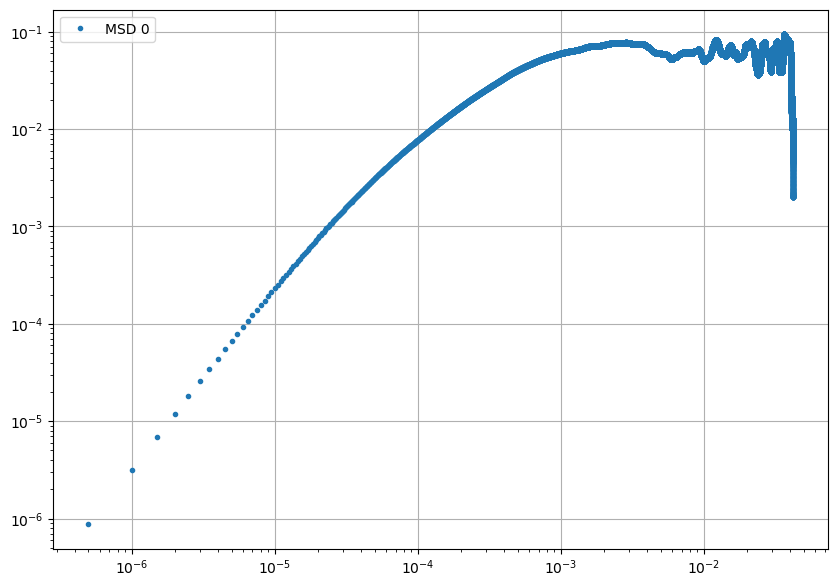

In [5]:
# PLOTTING
plt.figure(figsize=(10, 7))
# plt.plot(lag_times[1:], avg_msd, linewidth=.7, linestyle="dashed",label='Average MSD')

for i in range(1):
    plt.plot(lag_times, all_msd[i], ".",label=f'MSD {i}')


    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    # plt.xlim(right = 3e-6)
    # plt.ylim(top=1e-3)
    plt.grid(True)
    plt.show()


2796


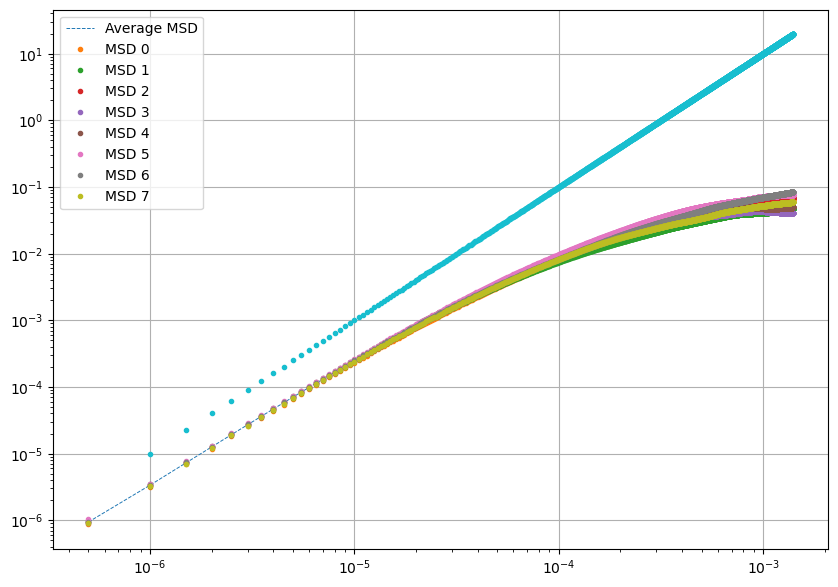

In [22]:
# CUT THE MSD DOWN TO A REASONABLE SIZE
max_len = int(len(lag_times)/30.0)
print(max_len)
lag_times_ = lag_times[:max_len]
avg_msd_ = avg_msd[:max_len]
all_msd_ = []

for i in range(len(all_msd)):
    all_msd_.append(all_msd[i][:max_len])

plt.figure(figsize=(10, 7))
plt.plot(lag_times_, avg_msd_, linewidth=.7, linestyle="dashed",label='Average MSD')

for i in range(len(all_msd)):
    plt.plot(lag_times_, all_msd_[i], ".", linewidth=.7,label=f'MSD {i}')

plt.plot(lag_times_[1:], lag_times_[1:]**2*1e7, ".")
plt.legend()
plt.xscale("log")
plt.yscale("log")
# plt.ylim(top=2e-4, bottom=1e-4)
plt.grid(True)
plt.show()


In [23]:
# # # FITTING THE AVERAGE
# bounds = [(1e-10, None), (1e-10, None),(1e-10, None)]
# params = MSD_fitting_const_rho(lag_times_, avg_msd_, 10, 9, 10, 1, bounds = bounds)
# print(params)
# p = params.x
# V = p[0] *V_const
# a = p[1]*10**-6
# m = 4/3*np.pi*a**3*(Const.BaTi_density + Const.rho_f / 2)
# K = p[2] * 10**-6
#
# scaled_msd_data = avg_msd_/V
# final_msd_fit = MSD_fitting_func(lag_times_, m, K, a, 1)


In [24]:
# individual_params = []
# inndividual_scaled_msd = []
# individual_fits = []
#
# all_a = []
# all_v = []
# all_m = []
# all_k = []
#
# for msd in all_msd_:
#     params1 = MSD_fitting_const_rho(lag_times_, msd, 10, 9, 10, 1,  bounds = bounds)
#     p1 = params1.x
#     V1 = p1[0] *V_const
#     a1 = p1[1]*10**-6
#     m1 = 4/3*np.pi*a1**3*(Const.BaTi_density + Const.rho_f / 2)
#     K1 = p1[2] * 10**-6
#
#
#     all_v.append(V1)
#     all_a.append(a1)
#     all_m.append(m1)
#     all_k.append(K1)
#
#     print(f"v is {V1}, a is {a1}, m is {m1}, K is {K1}")
#
#     scaled_msd_data1 = msd/V1
#     final_msd_fit1 = MSD_fitting_func(lag_times_, m1, K1, a1, 1)
#
#     individual_params.append(params1)
#     individual_fits.append(final_msd_fit1)
#     inndividual_scaled_msd.append(scaled_msd_data1)

In [25]:

# print(f"v is {V}, a is {a}, m is {m}, K is {K}")
#
# plt.figure(figsize=(10, 7))
# plt.plot(lag_times_, scaled_msd_data, ".",linewidth=.6, label='Avg MSD')
# plt.plot(lag_times_, final_msd_fit, linewidth=.6, label='Model')
# plt.xscale("log")
# plt.yscale("log")
# plt.show()
#
# for i in range(len(individual_fits)):
#     plt.plot(lag_times_, inndividual_scaled_msd[i], ".",linewidth=.6, label=f'MSD data {i}')
#     plt.plot(lag_times_, individual_fits[i], linewidth=.6, label=f'Model {i}')
#     print(individual_params[i])
#
#     plt.xscale("log")
#     plt.yscale("log")
#     plt.legend()
#     plt.show()
# #
# # plt.xscale("log")
# # plt.yscale("log")
# # plt.legend()
# plt.show()


In [26]:
# WEIGHT THE HIGH FREQ DATA MORE HEAVILY ...

def remove_data_points(lagtimes_, msd_, num_points):
    bottom = 20
    powers = np.linspace(1, 5, num_points)
    ls = np.array(np.floor(10**powers), dtype=np.int64) * bin_number / sampling_rate
    mask = ls >= lagtimes_[bottom]
    ls_f = ls[mask]

    lagtimes = np.array(lagtimes_)
    msd = np.array(msd_)

    remove = []
    start = bottom

    for i in range(len(ls_f)-1):
        if lagtimes[start] < ls_f[i]:
            if start > len(lagtimes) - 2:
                break
            start += 1
            while start < len(lagtimes)-1 and lagtimes[start] < ls_f[i]:
                remove.append(start)
                start += 1

    l_ret = np.delete(lagtimes, remove)
    m_ret = np.delete(msd, remove)
    return l_ret, m_ret

down_lag = 0
all_down_msd = []

for msd in all_msd_:
    down_lag, down_msd = remove_data_points(lag_times_, msd, 100)
    all_down_msd.append(down_msd)



v is 304440289755839.8, a is 2.6074130707942467e-06, m is 3.337332739380208e-13, K is 3.553039360976038e-05
v is 258835258759133.7, a is 2.396488290386523e-06, m is 2.5911701259490873e-13, K is 4.973611452550399e-05
v is 392683751716774.06, a is 2.7896149606532983e-06, m is 4.0869825603491746e-13, K is 4.464851420530482e-05
v is 378050484987968.0, a is 2.781395459636484e-06, m is 4.0509624559124413e-13, K is 7.353814340759992e-05
v is 415460832417776.3, a is 2.828464267415086e-06, m is 4.260122464294558e-13, K is 7.005114157309916e-05
v is 465640563897099.2, a is 2.9337860719157504e-06, m is 4.753957790473848e-13, K is 4.942755987088082e-05
v is 320250521149744.25, a is 2.5772683207495913e-06, m is 3.222915363025738e-13, K is 2.9865824779779883e-05
v is 310273353810993.25, a is 2.583790957433112e-06, m is 3.2474473300261386e-13, K is 4.659564076044017e-05
       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.0203663919

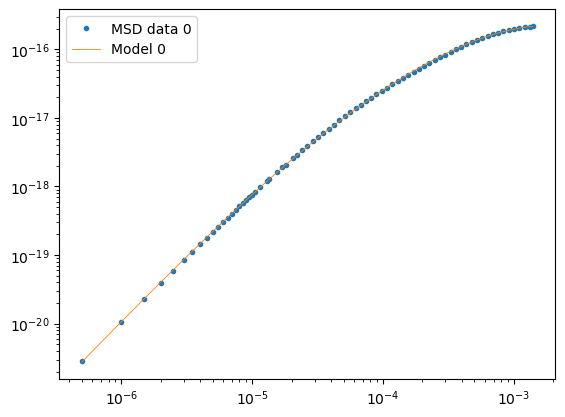

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.13068583873224168
             x: [ 2.588e+00  2.396e+00  4.974e+01]
           nit: 266
          nfev: 542
 final_simplex: (array([[ 2.588e+00,  2.396e+00,  4.974e+01],
                       [ 2.588e+00,  2.396e+00,  4.974e+01],
                       [ 2.588e+00,  2.396e+00,  4.974e+01],
                       [ 2.588e+00,  2.396e+00,  4.974e+01]]), array([ 1.307e-01,  1.307e-01,  1.307e-01,  1.307e-01]))


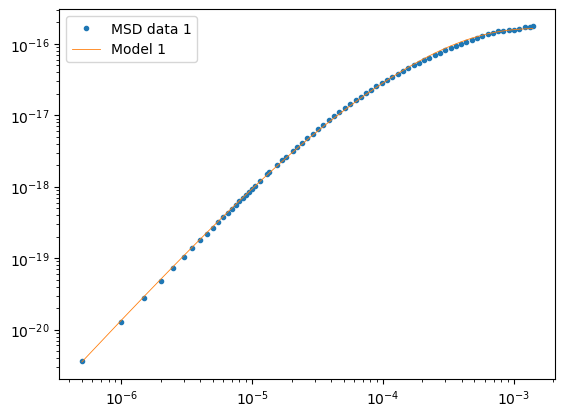

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.032448013686045885
             x: [ 3.927e+00  2.790e+00  4.465e+01]
           nit: 242
          nfev: 521
 final_simplex: (array([[ 3.927e+00,  2.790e+00,  4.465e+01],
                       [ 3.927e+00,  2.790e+00,  4.465e+01],
                       [ 3.927e+00,  2.790e+00,  4.465e+01],
                       [ 3.927e+00,  2.790e+00,  4.465e+01]]), array([ 3.245e-02,  3.245e-02,  3.245e-02,  3.245e-02]))


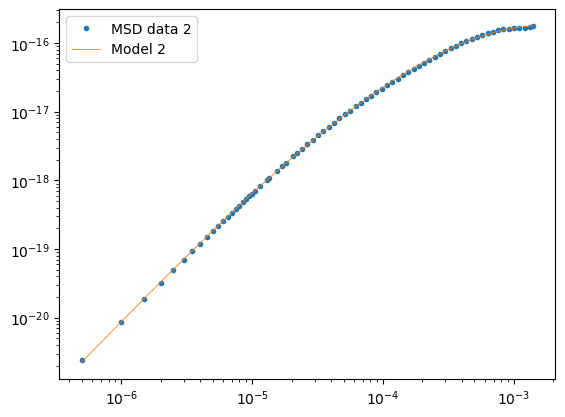

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.014572550818559045
             x: [ 3.781e+00  2.781e+00  7.354e+01]
           nit: 240
          nfev: 486
 final_simplex: (array([[ 3.781e+00,  2.781e+00,  7.354e+01],
                       [ 3.781e+00,  2.781e+00,  7.354e+01],
                       [ 3.781e+00,  2.781e+00,  7.354e+01],
                       [ 3.781e+00,  2.781e+00,  7.354e+01]]), array([ 1.457e-02,  1.457e-02,  1.457e-02,  1.457e-02]))


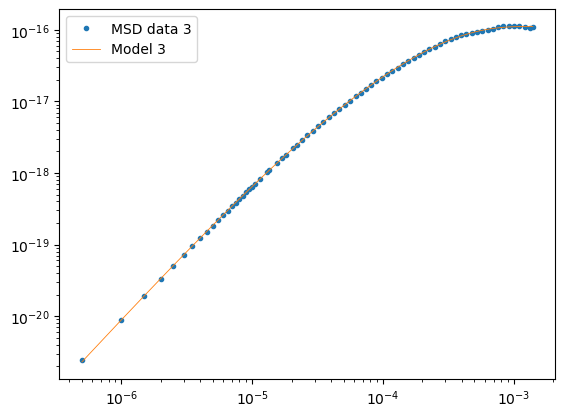

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.054056579889859825
             x: [ 4.155e+00  2.828e+00  7.005e+01]
           nit: 10000
          nfev: 49224
 final_simplex: (array([[ 4.155e+00,  2.828e+00,  7.005e+01],
                       [ 4.155e+00,  2.828e+00,  7.005e+01],
                       [ 4.155e+00,  2.828e+00,  7.005e+01],
                       [ 4.155e+00,  2.828e+00,  7.005e+01]]), array([ 5.406e-02,  5.406e-02,  5.406e-02,  5.406e-02]))


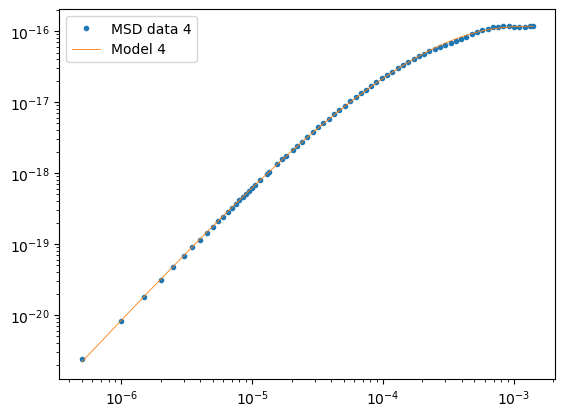

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.02371896865565188
             x: [ 4.656e+00  2.934e+00  4.943e+01]
           nit: 10000
          nfev: 49345
 final_simplex: (array([[ 4.656e+00,  2.934e+00,  4.943e+01],
                       [ 4.656e+00,  2.934e+00,  4.943e+01],
                       [ 4.656e+00,  2.934e+00,  4.943e+01],
                       [ 4.656e+00,  2.934e+00,  4.943e+01]]), array([ 2.372e-02,  2.372e-02,  2.372e-02,  2.372e-02]))


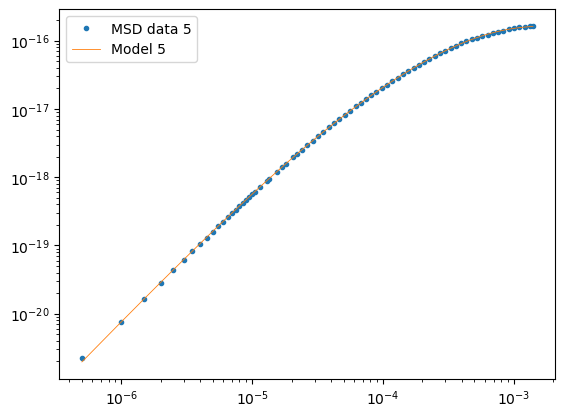

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.04078525797336725
             x: [ 3.203e+00  2.577e+00  2.987e+01]
           nit: 241
          nfev: 492
 final_simplex: (array([[ 3.203e+00,  2.577e+00,  2.987e+01],
                       [ 3.203e+00,  2.577e+00,  2.987e+01],
                       [ 3.203e+00,  2.577e+00,  2.987e+01],
                       [ 3.203e+00,  2.577e+00,  2.987e+01]]), array([ 4.079e-02,  4.079e-02,  4.079e-02,  4.079e-02]))


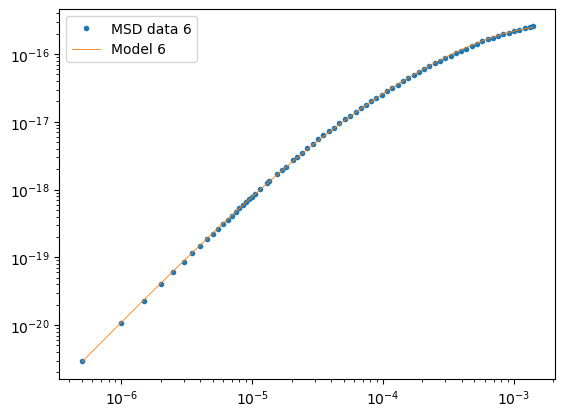

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.133621626984165
             x: [ 3.103e+00  2.584e+00  4.660e+01]
           nit: 10000
          nfev: 49319
 final_simplex: (array([[ 3.103e+00,  2.584e+00,  4.660e+01],
                       [ 3.103e+00,  2.584e+00,  4.660e+01],
                       [ 3.103e+00,  2.584e+00,  4.660e+01],
                       [ 3.103e+00,  2.584e+00,  4.660e+01]]), array([ 1.336e-01,  1.336e-01,  1.336e-01,  1.336e-01]))


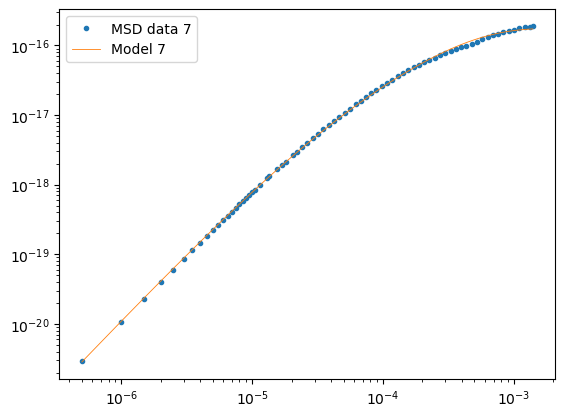

MEAN a: 2.6872776748730117e-06 STD a: 1.6346998997970095e-07 Mean k: 4.9924166591546146e-05 std k: 1.4192543702545755e-05 mean V: 355704382061916.06 std V: 64086083047154.74


In [27]:
# FIT AGAIN With Log sampling

individual_params2 = []
inndividual_scaled_msd2 = []
individual_fits2 = []

all_a = []
all_v = []
all_m = []
all_k = []

for msd in all_down_msd:
    params1 = MSD_fitting_const_rho(down_lag, msd, 10, 9, 10, 1,  bounds = bounds)
    p1 = params1.x
    V1 = p1[0] *V_const
    a1 = p1[1]*10**-6
    m1 = 4/3*np.pi*a1**3*(Const.BaTi_density + Const.rho_f / 2)
    K1 = p1[2] * 10**-6
    print(f"v is {V1}, a is {a1}, m is {m1}, K is {K1}")

    all_v.append(V1)
    all_a.append(a1)
    all_m.append(m1)
    all_k.append(K1)

    scaled_msd_data1 = msd/V1
    final_msd_fit1 = MSD_fitting_func(down_lag, m1, K1, a1, 1)

    individual_params2.append(params1)
    individual_fits2.append(final_msd_fit1)
    inndividual_scaled_msd2.append(scaled_msd_data1)


for i in range(len(individual_fits2)):
    plt.plot(down_lag, inndividual_scaled_msd2[i], ".",linewidth=.6, label=f'MSD data {i}')
    plt.plot(down_lag, individual_fits2[i], linewidth=.6, label=f'Model {i}')
    print( str(individual_params2[i]))

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()
#
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
plt.show()

print(f"MEAN a: {np.mean(all_a)} STD a: {np.std(all_a)} Mean k: {np.mean(all_k)} std k: {np.std(all_k)} mean V: {np.mean(all_v)} std V: {np.std(all_v)}")



v is 305059291288529.2, a is 2.610253719236831e-06, m is 3.3482522071535197e-13, K is 3.56313082179203e-05
v is 258064351810280.8, a is 2.392476190765115e-06, m is 2.5781778182008853e-13, K is 4.955501382229637e-05
index 0 is less than zero. model
index 0 is less than zero. model
index 0 is less than zero. model


C:\Users\mcthu\AppData\Local\Temp\ipykernel_18712\2870127383.py:72: RuntimeWarning:

invalid value encountered in log



v is 394847477827172.56, a is 2.7977752815705357e-06, m is 4.122953916770475e-13, K is 4.497405689695799e-05
v is 380697810644497.44, a is 2.7916319467280546e-06, m is 4.0958540519844377e-13, K is 7.414324448845055e-05
v is 419549096791588.94, a is 2.8430799036749734e-06, m is 4.3265048081525364e-13, K is 7.087178850927227e-05
v is 472760683194261.94, a is 2.957292018694046e-06, m is 4.869144101591302e-13, K is 5.041801733866704e-05
v is 319593281872156.25, a is 2.574327814022237e-06, m is 3.211896492011081e-13, K is 2.977654454112022e-05
v is 310091362584952.06, a is 2.5829136678972633e-06, m is 3.244140579136229e-13, K is 4.656160744383507e-05
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.01857842336688665
             x: [ 3.051e+00  2.610e+00  3.563e+01]
           nit: 286
          nfev: 581
 final_simplex: (array([[ 3.051e+00,  2.610e+00,  3.563e+01],
                       [ 3.051e+00,  2.610e+00,  3.563e+01],
   

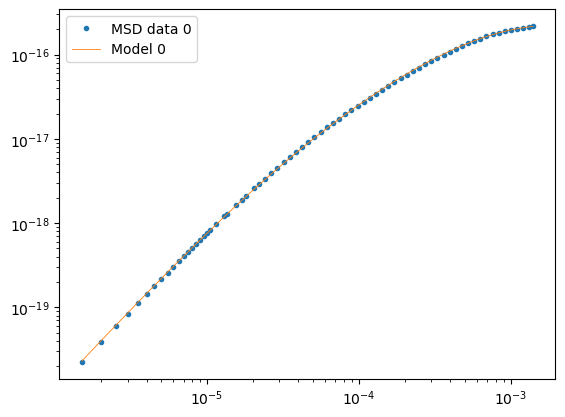

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.12745657340339156
             x: [ 2.581e+00  2.392e+00  4.956e+01]
           nit: 260
          nfev: 541
 final_simplex: (array([[ 2.581e+00,  2.392e+00,  4.956e+01],
                       [ 2.581e+00,  2.392e+00,  4.956e+01],
                       [ 2.581e+00,  2.392e+00,  4.956e+01],
                       [ 2.581e+00,  2.392e+00,  4.956e+01]]), array([ 1.275e-01,  1.275e-01,  1.275e-01,  1.275e-01]))


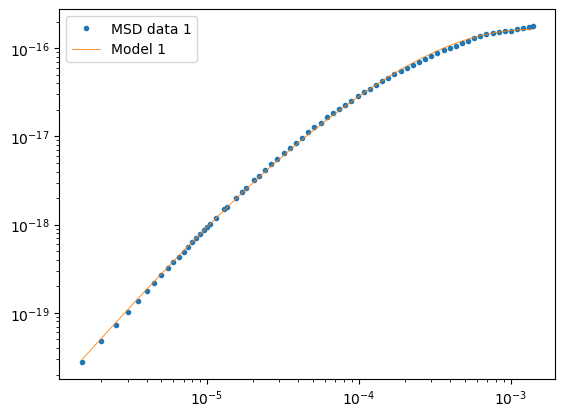

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.028805369695927112
             x: [ 3.948e+00  2.798e+00  4.497e+01]
           nit: 10000
          nfev: 49225
 final_simplex: (array([[ 3.948e+00,  2.798e+00,  4.497e+01],
                       [ 3.948e+00,  2.798e+00,  4.497e+01],
                       [ 3.948e+00,  2.798e+00,  4.497e+01],
                       [ 3.948e+00,  2.798e+00,  4.497e+01]]), array([ 2.881e-02,  2.881e-02,  2.881e-02,  2.881e-02]))


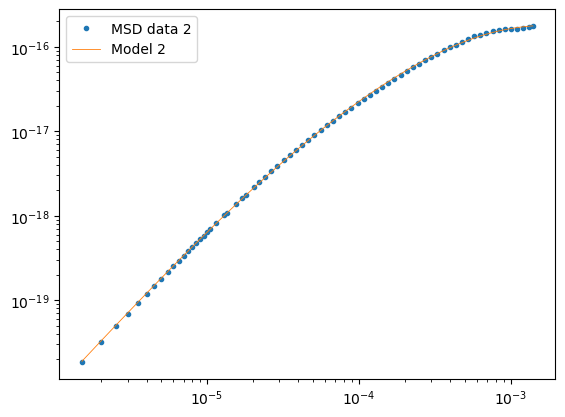

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.010785063751572087
             x: [ 3.807e+00  2.792e+00  7.414e+01]
           nit: 253
          nfev: 511
 final_simplex: (array([[ 3.807e+00,  2.792e+00,  7.414e+01],
                       [ 3.807e+00,  2.792e+00,  7.414e+01],
                       [ 3.807e+00,  2.792e+00,  7.414e+01],
                       [ 3.807e+00,  2.792e+00,  7.414e+01]]), array([ 1.079e-02,  1.079e-02,  1.079e-02,  1.079e-02]))


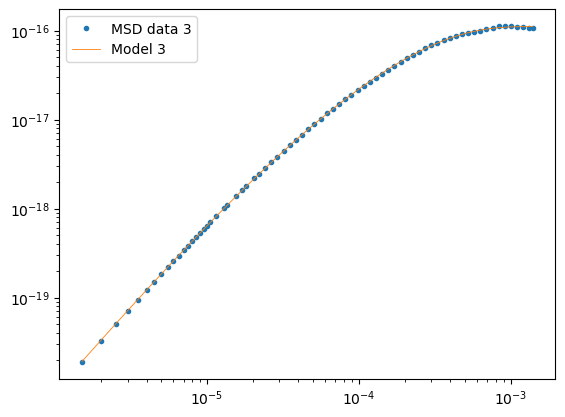

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.04561120429844977
             x: [ 4.195e+00  2.843e+00  7.087e+01]
           nit: 249
          nfev: 506
 final_simplex: (array([[ 4.195e+00,  2.843e+00,  7.087e+01],
                       [ 4.195e+00,  2.843e+00,  7.087e+01],
                       [ 4.195e+00,  2.843e+00,  7.087e+01],
                       [ 4.195e+00,  2.843e+00,  7.087e+01]]), array([ 4.561e-02,  4.561e-02,  4.561e-02,  4.561e-02]))


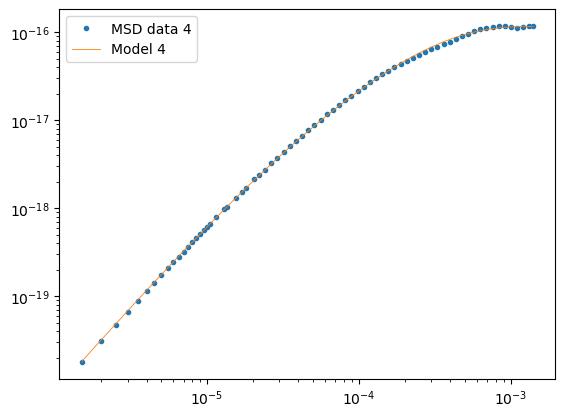

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.007242811163971298
             x: [ 4.728e+00  2.957e+00  5.042e+01]
           nit: 215
          nfev: 422
 final_simplex: (array([[ 4.728e+00,  2.957e+00,  5.042e+01],
                       [ 4.728e+00,  2.957e+00,  5.042e+01],
                       [ 4.728e+00,  2.957e+00,  5.042e+01],
                       [ 4.728e+00,  2.957e+00,  5.042e+01]]), array([ 7.243e-03,  7.243e-03,  7.243e-03,  7.243e-03]))


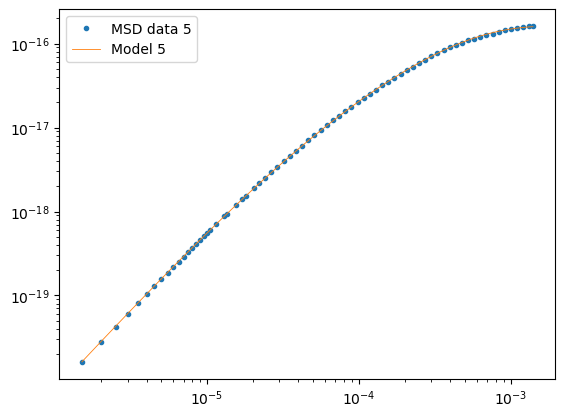

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0392569036491486
             x: [ 3.196e+00  2.574e+00  2.978e+01]
           nit: 244
          nfev: 504
 final_simplex: (array([[ 3.196e+00,  2.574e+00,  2.978e+01],
                       [ 3.196e+00,  2.574e+00,  2.978e+01],
                       [ 3.196e+00,  2.574e+00,  2.978e+01],
                       [ 3.196e+00,  2.574e+00,  2.978e+01]]), array([ 3.926e-02,  3.926e-02,  3.926e-02,  3.926e-02]))


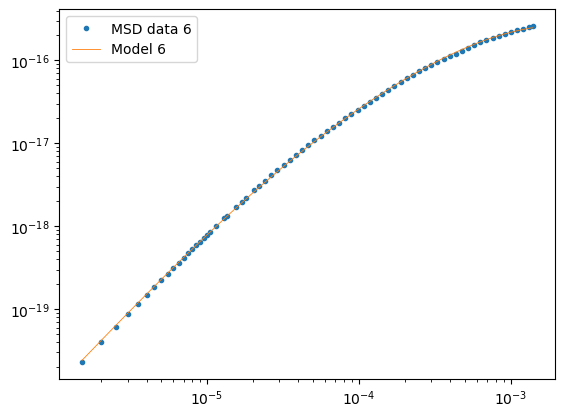

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.13175251992609704
             x: [ 3.101e+00  2.583e+00  4.656e+01]
           nit: 265
          nfev: 531
 final_simplex: (array([[ 3.101e+00,  2.583e+00,  4.656e+01],
                       [ 3.101e+00,  2.583e+00,  4.656e+01],
                       [ 3.101e+00,  2.583e+00,  4.656e+01],
                       [ 3.101e+00,  2.583e+00,  4.656e+01]]), array([ 1.318e-01,  1.318e-01,  1.318e-01,  1.318e-01]))


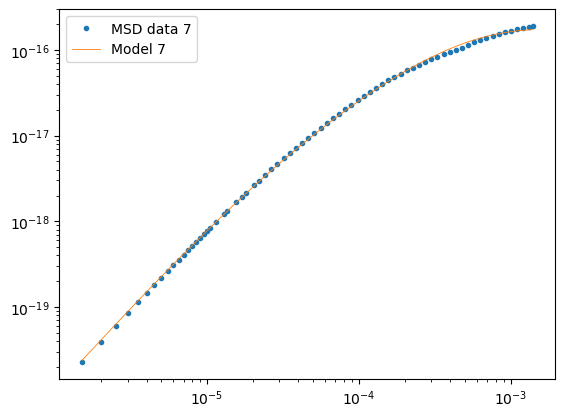

MEAN a: 2.693718817823632e-06 STD a: 1.7191561546339502e-07 Mean k: 5.024144765731498e-05 std k: 1.4452353991218364e-05 mean V: 357582919501679.9 std V: 66511284060023.64


In [28]:
# Fit again without first two data points
# WEIGHT THE HIGH FREQ DATA MORE HEAVILY ...

def remove_data_points_and_first_two(lagtimes_, msd_, num_points):
    bottom = 20
    powers = np.linspace(1, 5, num_points)
    ls = np.array(np.floor(10**powers), dtype=np.int64) * bin_number / sampling_rate
    mask = ls >= lagtimes_[bottom]
    ls_f = ls[mask]

    lagtimes = np.array(lagtimes_)
    msd = np.array(msd_)

    remove = [0,1]
    start = bottom

    for i in range(len(ls_f)-1):
        if lagtimes[start] < ls_f[i]:
            if start > len(lagtimes) - 2:
                break
            start += 1
            while start < len(lagtimes)-1 and lagtimes[start] < ls_f[i]:
                remove.append(start)
                start += 1

    l_ret = np.delete(lagtimes, remove)
    m_ret = np.delete(msd, remove)
    return l_ret, m_ret

down_lag_2 = 0
all_down_msd_2 = []

for msd in all_msd_:
    down_lag_2, down_msd = remove_data_points_and_first_two(lag_times_, msd, 100)
    all_down_msd_2.append(down_msd)

# FIT AGAIN With Log sampling

individual_params3 = []
inndividual_scaled_msd3 = []
individual_fits3 = []

all_a = []
all_v = []
all_m = []
all_k = []

for msd in all_down_msd_2:
    params1 = MSD_fitting_const_rho(down_lag_2, msd, 1, 3, 1, 1,  bounds = bounds)
    p1 = params1.x
    V1 = p1[0] *V_const
    a1 = p1[1]*10**-6
    m1 = 4/3*np.pi*a1**3*(Const.BaTi_density + Const.rho_f / 2)
    K1 = p1[2] * 10**-6
    print(f"v is {V1}, a is {a1}, m is {m1}, K is {K1}")

    all_v.append(V1)
    all_a.append(a1)
    all_m.append(m1)
    all_k.append(K1)

    scaled_msd_data1 = msd/V1
    final_msd_fit1 = MSD_fitting_func(down_lag_2, m1, K1, a1, 1)

    individual_params3.append(params1)
    individual_fits3.append(final_msd_fit1)
    inndividual_scaled_msd3.append(scaled_msd_data1)


for i in range(len(individual_fits3)):
    plt.plot(down_lag_2, inndividual_scaled_msd3[i], ".",linewidth=.6, label=f'MSD data {i}')
    plt.plot(down_lag_2, individual_fits3[i], linewidth=.6, label=f'Model {i}')
    print( str(individual_params3[i]))

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.show()
#
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
plt.show()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import numpy as np

print(f"MEAN a: {np.mean(all_a)} STD a: {np.std(all_a)} Mean k: {np.mean(all_k)} std k: {np.std(all_k)} mean V: {np.mean(all_v)} std V: {np.std(all_v)}")


In [29]:
import plotly.graph_objects as go
import numpy as np

# Use index as color
color_by_index = np.arange(len(all_a))

fig = go.Figure(data=[go.Scatter3d(
    x=all_a,
    y=all_v,
    z=all_k,
    mode='markers',
    marker=dict(
        size=5,
        color=color_by_index,
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='a Axis',
        yaxis_title='v Axis',
        zaxis_title='k Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()
